In [1]:
#import libraries
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
from keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from statistics import mean
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import Dense, Input, LSTM,GlobalMaxPool1D

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  f1_score

/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
##calculating ROC evaluation
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch + 1, score))

In [3]:
#import embedding files
EMBEDDING_word2vec= '../Embedding_Vecrots/GoogleNews-vectors-negative300.bin'
EMBEDDING_FastText = '../Embedding_Vecrots/crawl-300d-2M.vec'
EMBEDDING_GloVe= '../Embedding_Vecrots/glove.840B.300d.txt'

In [4]:
##import train and test data
train =pd.read_csv('../train.csv')
#train =pd.read_excel('../Models/code-review-dataset-full.xlsx')
#test =pd.read_excel('./Models/test.xlsx')

X_train = train["comment_text"].fillna("fillna").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [5]:
## set features
max_features = 30000
#max_features =17404
maxlen = 100
embed_size = 300

In [6]:
## some preprocessing
tokenizer = text.Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(list(X_train) + list(X_test))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train, maxlen=maxlen)

In [7]:
## applying the embedding vector
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')


#embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_GloVe,encoding='utf-8'))
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FastText))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    #if embedding_vector is not None: embedding_matrix[i] = embedding_vector

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
K.set_session(tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf))

In [8]:
def get_model_PooledGRU():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(6, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 160)     182880      spatial_dropout1d_1[0][0]       

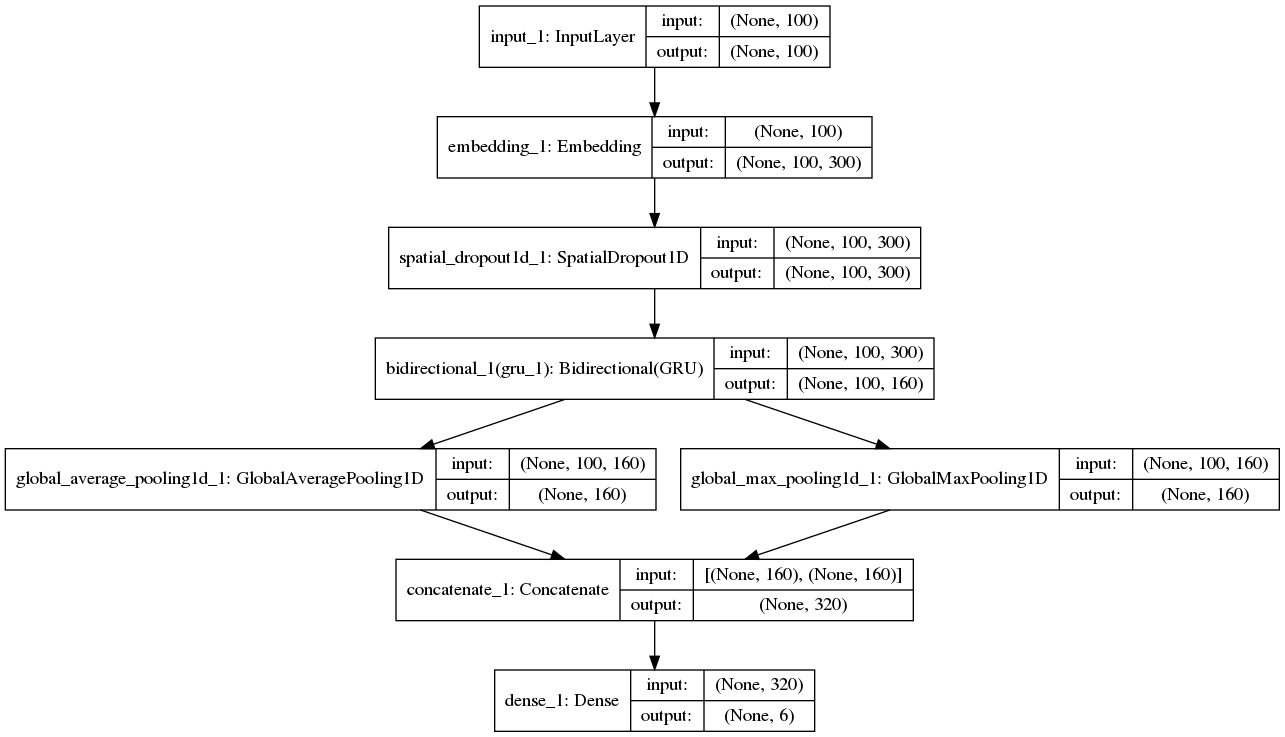

In [9]:
gru_model= get_model_PooledGRU()
from keras.utils.vis_utils import plot_model

gru_model.summary()
 
plot_model(gru_model, to_file='GRU.png', show_shapes=True, show_layer_names=True)

In [ ]:
 

from matplotlib import pyplot

batch_size = 32
epochs = 2

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

history = gru_model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)
 # plot training history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()


Train on 151592 samples, validate on 7979 samples
Epoch 1/2
151592/151592 [==============================] - 447s 3ms/step - loss: 0.0340 - accuracy: 0.9870 - val_loss: 0.0477 - val_accuracy: 0.9819

 ROC-AUC - epoch: 1 - score: 0.985773 

Epoch 2/2
125760/151592 [=======================>......] - ETA: 1:14 - loss: 0.0268 - accuracy: 0.9897